<a href="https://colab.research.google.com/github/skamble91/ML-Projects/blob/master/Ware2Go_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

In [ ]:
supply_df= pd.read_excel("/content/ds_w2g.xlsx", sheet_name=0)

In [ ]:
supply_df.describe()

,Units,SKUs,Zip,Wgt,Cubic,Length,Width,Height,S_Zip,R_Zip
count,78084.000000,78084.000000,78084.000000,78084.000000,78084.000000,78084.000000,78084.00000,78084.000000,78084.0,78075.000000
mean,2.501908,2.000295,52069.132447,13.801124,2189.467112,16.540482,12.25648,9.047667,29601.0,52068.087531
std,1.120362,0.815144,30730.292699,8.076700,1326.734232,4.176119,3.02276,2.999120,0.0,30731.060522
min,1.000000,1.000000,1002.000000,0.000000,70.000000,0.000000,0.00000,0.000000,29601.0,1002.000000
25%,1.000000,1.000000,27519.000000,6.000000,896.000000,13.000000,11.00000,8.000000,29601.0,27519.000000
50%,3.000000,2.000000,48386.000000,13.000000,2100.000000,15.000000,12.00000,10.000000,29601.0,48386.000000
75%,4.000000,3.000000,80304.000000,20.000000,3200.000000,20.000000,14.00000,10.000000,29601.0,80304.000000
max,4.000000,3.000000,99901.000000,95.000000,13650.000000,88.000000,25.00000,20.000000,29601.0,99901.000000


In [ ]:
tnt_df=pd.read_excel("/content/ds_w2g.xlsx", sheet_name=1, skiprows=2, header=0)

In [ ]:
tnt_df.columns

Index(['To ZIP code', 'To City', 'To  State', 'Abbreviation', 'Val Zip', 'ST',
       '3 Dig Val', 'ST.1', '60403 Zone', '60403 Days', '84044 Zone',
       '84044 Days', '17026 Zone', '17026 Days', '64030 Zone', '64030 Days',
       '23232 Zone', '23232 Days', '38114 Zone', '38114 Days', '93404 Zone',
       '93404 Days', '90023 Zone', '90023 Days', '33182 Zone', '33182 Days',
       '30349 Zones', '30349 Days', '37416 Zones', '37416 Days', '89431 Zones',
       '89431 Days', '97701 Zone', '97701 Days', '75006 Zone', '75006 Days',
       '29601 Zone', '29601 Days'],
      dtype='object')

In [ ]:
tnt_df.describe()

tnt_df['Min_value']=tnt_df.iloc[:,10:25].min(axis=1)
tnt_df['Min_index']=tnt_df.iloc[:,10:25].idxmin(axis=1)


In [ ]:
replace_values = {'60403 Days':'Aurora, IL',
 '84044 Days':'Salt Lake City, UT',
 '17026 Days':'Mt Joy, PA',
 '64030 Days':'Kansas City, MO',
 '23232 Days':'Richmond, VA',
 '38114 Days':'Memphis, TN',
 '93404 Days': 'Santa Maria, CA',
 '90023 Days': 'Los Angeles, CA',
 '33182 Days': 'Miami, FL',
 '30349 Days':'Atlanta, GA',
 '37416 Days': 'Chattanooga, TN',
 '89431 Days': 'Sparks/Reno, NV' ,
 '97701 Days': 'Bend OR',
 '75006 Days':'Dallas/Coppell, TX ',
 '29601 Days':'Greenville, SC'}  

tnt_df=tnt_df.replace({'Min_index':replace_values})

In [ ]:
def service_text(text):
  if text.startswith("GROUND"):
    return "GROUND"
  elif text.startswith("2ND"):
    return "2ND DAY"
  elif text.startswith("3 DAY"):
    return "3 DAY"
  elif text.startswith("NEXT"):
    return "NEXT DAY"
  else:
    return "UNKNOWN"

supply_df["Service_Type"]= supply_df["Service_Text"].apply(service_text)


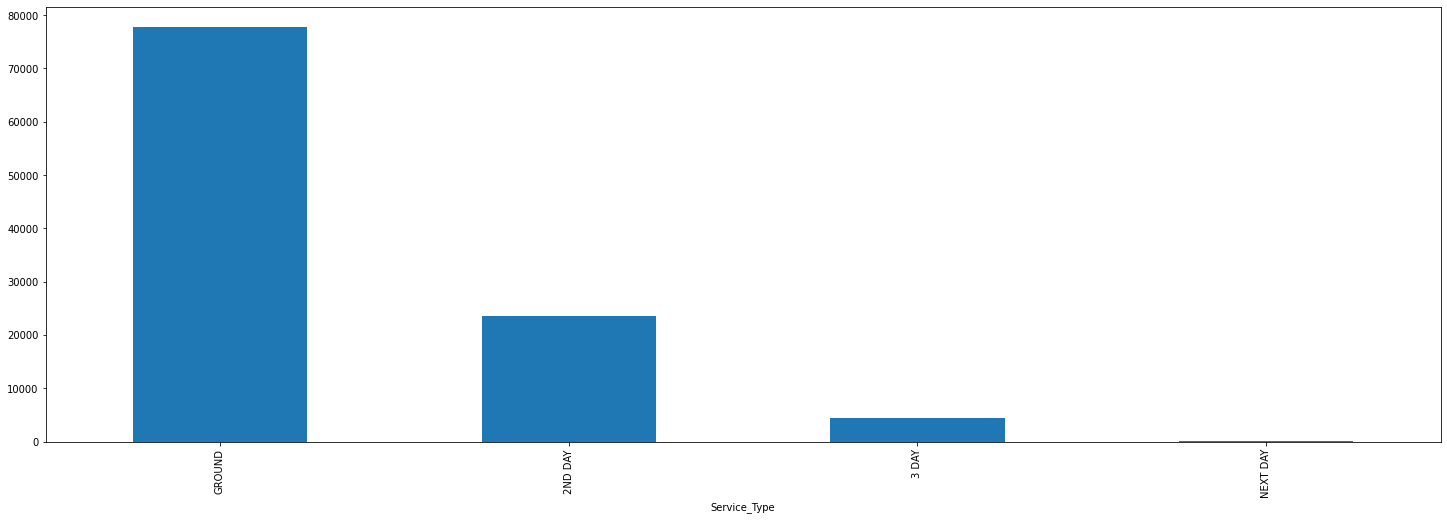

In [ ]:
supply_df.groupby("Service_Text")['Track_Num'].count().nlargest(100).plot(kind="bar", figsize=(25,8))
supply_df.groupby("Service_Type")['Track_Num'].count().nlargest(100).plot(kind="bar", figsize=(25,8))

In [ ]:
supply_df['PUDate']= pd.to_datetime(supply_df['PUDate'])
supply_df['PU Year'], supply_df['PU Month'], supply_df['PU Week']=supply_df['PUDate'].dt.year, supply_df['PUDate'].dt.month, supply_df['PUDate'].dt.week

supply_df.columns

Index(['Track_Num', 'Service_Text', 'PUDate', 'Units ', 'SKUs', 'Zip', 'Wgt',
       'Wgt_UOM', 'Cubic', 'Length ', 'Width ', 'Height ', 'Dim_UOM',
       'S_Cntry', 'R_Cntry', 'S_City', 'S_State', 'S_Zip', 'R_City', 'R_State',
       'R_Zip', 'Service_Type', 'PU Year', 'PU Month', 'PU Week'],
      dtype='object')

In [ ]:
supply_df['PU Quarter']=supply_df['PUDate'].dt.quarter

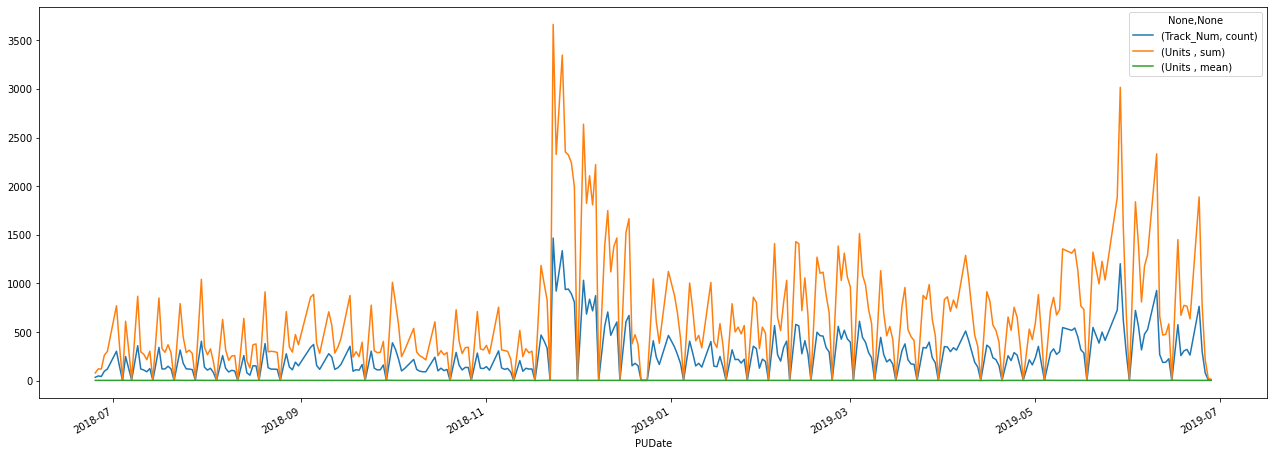

In [ ]:
supply_df.groupby("PUDate").agg({'Track_Num':"count",'Units ': ["sum","mean"]}).plot(figsize=(22,8))


In [ ]:
join_df=supply_df.set_index('Zip').join(tnt_df.set_index('To ZIP code'), how='left')

In [ ]:
len(join_df)

78084

In [ ]:
join_df

from google.colab import files
join_df.to_csv('join_df.csv')
files.download('join_df.csv')

In [ ]:
time_df= pd.DataFrame(supply_df.groupby('PUDate')['Units '].sum())
#time_df.rename(columns={"PUDate":'ds', "Units ":'y'}, inplace=True)

time_df.reset_index(inplace=True)
time_df.rename(columns={"PUDate":'ds', "Units ":'y'}, inplace=True)

In [ ]:

m=Prophet(interval_width=0.95, weekly_seasonality=True)
m.fit(time_df)
future = m.make_future_dataframe(periods=30)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
324,2019-07-24
325,2019-07-25
326,2019-07-26
327,2019-07-27
328,2019-07-28


In [ ]:
forecast = m.predict(future)

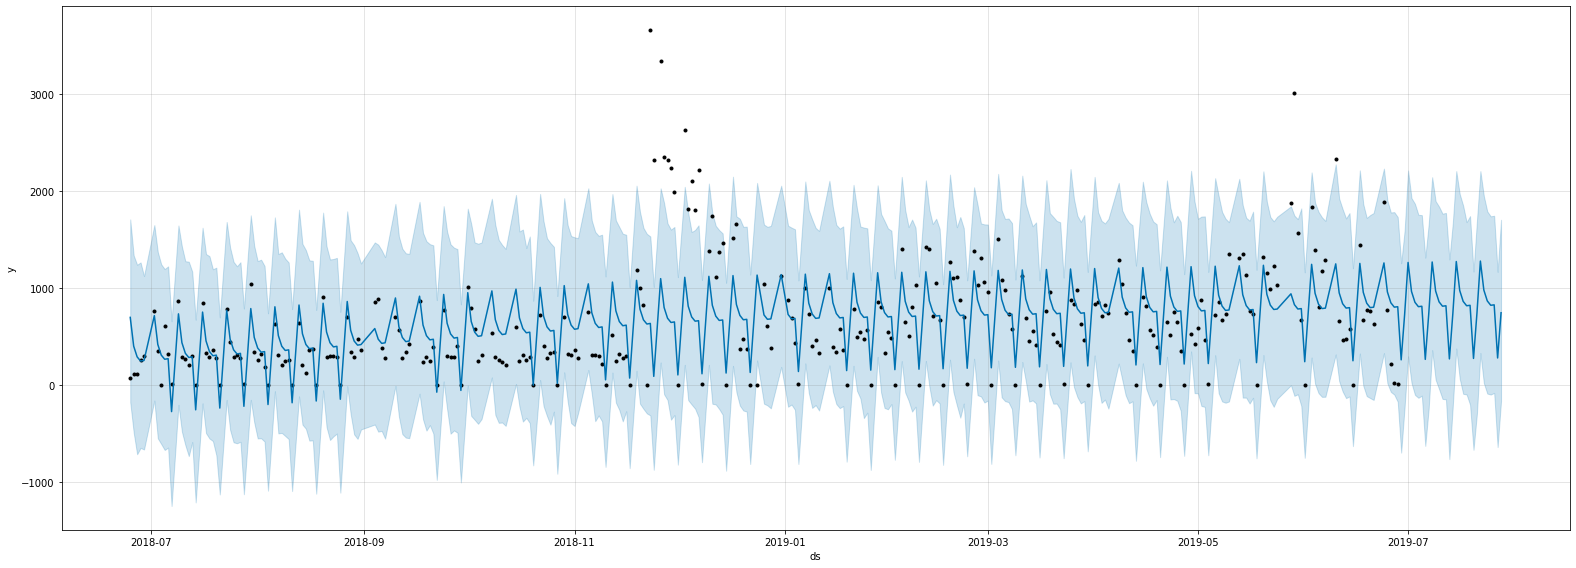

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast, figsize=(22,8))

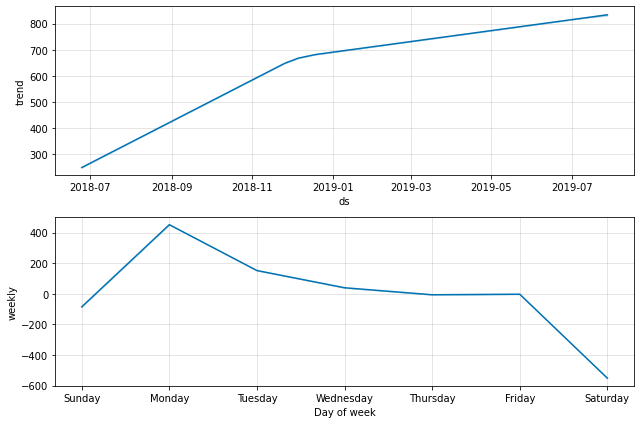

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
supply_final=pd.get_dummies(supply_df, columns=['Service_Type', 'SKUs', 'PU Year', 'PU Quarter'])
supply_final.head()

,Track_Num,Service_Text,PUDate,Units,Zip,Wgt,Wgt_UOM,Cubic,Length,Width,Height,Dim_UOM,S_Cntry,R_Cntry,S_City,S_State,S_Zip,R_City,R_State,R_Zip,PU Month,PU Week,Service_Type_2ND DAY,Service_Type_3 DAY,Service_Type_GROUND,Service_Type_NEXT DAY,SKUs_1,SKUs_2,SKUs_3,PU Year_2018,PU Year_2019,PU Quarter_1,PU Quarter_2,PU Quarter_3,PU Quarter_4
0,1Z00E0W70390804161,GROUND RESIDENTIAL,2018-06-25,1,30101,19,Lbs,3024,21,12,12,IN,US,US,Greenville,SC,29601,ACWORTH,GA,30101.0,6,26,0,0,1,0,0,1,0,1,0,0,1,0,0
1,1Z00E0W70394853913,GROUND RESIDENTIAL,2018-06-25,4,33043,3,Lbs,429,13,11,3,IN,US,US,Greenville,SC,29601,BIG PINE KEY,FL,33043.0,6,26,0,0,1,0,1,0,0,1,0,0,1,0,0
2,1Z00E0W70395071239,GROUND RESIDENTIAL,2018-06-25,1,48154,11,Lbs,1680,14,12,10,IN,US,US,Greenville,SC,29601,LIVONIA,MI,48154.0,6,26,0,0,1,0,0,1,0,1,0,0,1,0,0
3,1Z00E0W70395876361,GROUND RESIDENTIAL,2018-06-25,4,14424,3,Lbs,429,13,11,3,IN,US,US,Greenville,SC,29601,CANANDAIGUA,NY,14424.0,6,26,0,0,1,0,1,0,0,1,0,0,1,0,0
4,1Z00E0W70396104200,GROUND RESIDENTIAL,2018-06-25,2,25411,11,Lbs,1680,14,12,10,IN,US,US,Greenville,SC,29601,BERKELEY SPGS,WV,25411.0,6,26,0,0,1,0,0,1,0,1,0,0,1,0,0


In [ ]:
supply_final.columns

Index(['Track_Num', 'Service_Text', 'PUDate', 'Units ', 'Zip', 'Wgt',
       'Wgt_UOM', 'Cubic', 'Length ', 'Width ', 'Height ', 'Dim_UOM',
       'S_Cntry', 'R_Cntry', 'S_City', 'S_State', 'S_Zip', 'R_City', 'R_State',
       'R_Zip', 'PU Month', 'PU Week', 'Service_Type_2ND DAY',
       'Service_Type_3 DAY', 'Service_Type_GROUND', 'Service_Type_NEXT DAY',
       'SKUs_1', 'SKUs_2', 'SKUs_3', 'PU Year_2018', 'PU Year_2019',
       'PU Quarter_1', 'PU Quarter_2', 'PU Quarter_3', 'PU Quarter_4'],
      dtype='object')

In [ ]:
supply_final=supply_final.groupby(["Zip", "R_City"]).agg({'Track_Num':"count",
                                          'Units ': ["sum","mean"], 
                                          'SKUs_1':"mean", 'SKUs_2':"mean", 'SKUs_3':"mean", 
                                          'Service_Type_2ND DAY':"mean",'Service_Type_3 DAY':"mean", 	'Service_Type_GROUND' :"mean",	'Service_Type_NEXT DAY' :"mean",
                                          'Wgt':["sum", "mean"],
                                          'Cubic':["sum", "mean"],
                                          'Length ':["sum", "mean"],
                                          'Width ':["sum", "mean"],
                                          'Height ':["sum", "mean"], 
                                          'PU Year_2018':"count",	'PU Year_2019':"count" ,
                                          'PU Quarter_1':"count" ,	'PU Quarter_2':"count" ,	'PU Quarter_3':"count", 	'PU Quarter_4':"count" })

In [ ]:
supply_final.reset_index(inplace=True)

In [ ]:
supply_final

Zip       R_City Track_Num  ... PU Quarter_2 PU Quarter_3 PU Quarter_4
                              count  ...        count        count        count
0       1002      AMHERST        20  ...           20           20           20
1       1007  BELCHERTOWN         1  ...            1            1            1
2       1013     CHICOPEE         4  ...            4            4            4
3       1020     CHICOPEE         8  ...            8            8            8
4       1022     CHICOPEE         3  ...            3            3            3
...      ...          ...       ...  ...          ...          ...          ...
15526  99654      WASILLA         2  ...            2            2            2
15527  99669     SOLDOTNA         1  ...            1            1            1
15528  99672     STERLING         1  ...            1            1            1
15529  99801       JUNEAU         2  ...            2            2            2
15530  99901    KETCHIKAN         1  ...            1            1            1

[15531 rows x 28 columns]

In [ ]:
join_df=supply_final.set_index('Zip').join(tnt_df.set_index('To ZIP code'), how='left')

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



In [ ]:
join_df.columns=("".join(x) for x in join_df.columns.ravel())
join_df.columns

Index(['R_City', 'Track_Numcount', 'Units sum', 'Units mean', 'SKUs_1mean',
       'SKUs_2mean', 'SKUs_3mean', 'Service_Type_2ND DAYmean',
       'Service_Type_3 DAYmean', 'Service_Type_GROUNDmean',
       'Service_Type_NEXT DAYmean', 'Wgtsum', 'Wgtmean', 'Cubicsum',
       'Cubicmean', 'Length sum', 'Length mean', 'Width sum', 'Width mean',
       'Height sum', 'Height mean', 'PU Year_2018count', 'PU Year_2019count',
       'PU Quarter_1count', 'PU Quarter_2count', 'PU Quarter_3count',
       'PU Quarter_4count', 'To City', 'To  State', 'Abbreviation', 'Val Zip',
       'ST', '3 Dig Val', 'ST.1', '60403 Zone', '60403 Days', '84044 Zone',
       '84044 Days', '17026 Zone', '17026 Days', '64030 Zone', '64030 Days',
       '23232 Zone', '23232 Days', '38114 Zone', '38114 Days', '93404 Zone',
       '93404 Days', '90023 Zone', '90023 Days', '33182 Zone', '33182 Days',
       '30349 Zones', '30349 Days', '37416 Zones', '37416 Days', '89431 Zones',
       '89431 Days', '97701 Zone', '97701 

In [ ]:
days_cols= [i for i in join_df.columns if i.endswith("Days")]


In [ ]:
others_cols=['R_City', 'Track_Numcount', 'Units sum', 'Units mean', 'SKUs_1mean',
       'SKUs_2mean', 'SKUs_3mean', 'Service_Type_2ND DAYmean',
       'Service_Type_3 DAYmean', 'Service_Type_GROUNDmean',
       'Service_Type_NEXT DAYmean', 'Wgtsum', 'Wgtmean', 'Cubicsum',
       'Cubicmean', 'Length sum', 'Length mean', 'Width sum', 'Width mean',
       'Height sum', 'Height mean', 'PU Year_2018count', 'PU Year_2019count',
       'PU Quarter_1count', 'PU Quarter_2count', 'PU Quarter_3count',
       'PU Quarter_4count']
days_cols.extend(others_cols)
days_cols

['60403 Days',
 '84044 Days',
 '17026 Days',
 '64030 Days',
 '23232 Days',
 '38114 Days',
 '93404 Days',
 '90023 Days',
 '33182 Days',
 '30349 Days',
 '37416 Days',
 '89431 Days',
 '97701 Days',
 '75006 Days',
 '29601 Days',
 'R_City',
 'Track_Numcount',
 'Units sum',
 'Units mean',
 'SKUs_1mean',
 'SKUs_2mean',
 'SKUs_3mean',
 'Service_Type_2ND DAYmean',
 'Service_Type_3 DAYmean',
 'Service_Type_GROUNDmean',
 'Service_Type_NEXT DAYmean',
 'Wgtsum',
 'Wgtmean',
 'Cubicsum',
 'Cubicmean',
 'Length sum',
 'Length mean',
 'Width sum',
 'Width mean',
 'Height sum',
 'Height mean',
 'PU Year_2018count',
 'PU Year_2019count',
 'PU Quarter_1count',
 'PU Quarter_2count',
 'PU Quarter_3count',
 'PU Quarter_4count']

In [ ]:
final_df.iloc[:, 0:15]

,60403 Days,84044 Days,17026 Days,64030 Days,23232 Days,38114 Days,93404 Days,90023 Days,33182 Days,30349 Days,37416 Days,89431 Days,97701 Days,75006 Days,29601 Days
1002,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0
1007,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0
1013,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0
1020,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0
1022,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_df=join_df[days_cols]
final_df['Min_value']=final_df.iloc[:,0:15].min(axis=1)
final_df['Min_index']=final_df.iloc[:,0:15].idxmin(axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
final_df

,60403 Days,84044 Days,17026 Days,64030 Days,23232 Days,38114 Days,93404 Days,90023 Days,33182 Days,30349 Days,37416 Days,89431 Days,97701 Days,75006 Days,29601 Days,R_City,Track_Numcount,Units sum,Units mean,SKUs_1mean,SKUs_2mean,SKUs_3mean,Service_Type_2ND DAYmean,Service_Type_3 DAYmean,Service_Type_GROUNDmean,Service_Type_NEXT DAYmean,Wgtsum,Wgtmean,Cubicsum,Cubicmean,Length sum,Length mean,Width sum,Width mean,Height sum,Height mean,PU Year_2018count,PU Year_2019count,PU Quarter_1count,PU Quarter_2count,PU Quarter_3count,PU Quarter_4count,total_days,Mean_days,Min_value,Min_index
1002,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,AMHERST,20,56,2.800000,0.40,0.25,0.35,0.0,0.0,1.0,0.0,190,9.50,29511,1475.550000,289,14.450,217,10.850000,161,8.050000,20,20,20,20,20,20,54.0,3.6,2.0,17026 Days
1007,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,BELCHERTOWN,1,3,3.000000,0.00,1.00,0.00,0.0,0.0,1.0,0.0,13,13.00,2100,2100.000000,15,15.000,14,14.000000,10,10.000000,1,1,1,1,1,1,54.0,3.6,2.0,17026 Days
1013,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,CHICOPEE,4,10,2.500000,0.25,0.50,0.25,0.0,0.0,1.0,0.0,13,3.25,1875,468.750000,51,12.750,40,10.000000,16,4.000000,4,4,4,4,4,4,54.0,3.6,2.0,17026 Days
1020,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,CHICOPEE,8,16,2.000000,0.50,0.25,0.25,0.0,0.0,1.0,0.0,100,12.50,15717,1964.625000,129,16.125,96,12.000000,64,8.000000,8,8,8,8,8,8,54.0,3.6,2.0,17026 Days
1022,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,CHICOPEE,3,5,1.666667,0.00,1.00,0.00,0.0,0.0,1.0,0.0,48,16.00,7616,2538.666667,54,18.000,40,13.333333,28,9.333333,3,3,3,3,3,3,54.0,3.6,2.0,17026 Days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WASILLA,2,5,2.500000,0.00,0.50,0.50,0.0,0.0,1.0,0.0,39,19.50,6300,3150.000000,42,21.000,24,12.000000,24,12.000000,2,2,2,2,2,2,0.0,NaN,NaN,NaN
99669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SOLDOTNA,1,3,3.000000,0.00,0.00,1.00,0.0,0.0,1.0,0.0,4,4.00,588,588.000000,12,12.000,7,7.000000,7,7.000000,1,1,1,1,1,1,0.0,NaN,NaN,NaN
99672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STERLING,1,1,1.000000,0.00,0.00,1.00,0.0,0.0,1.0,0.0,4,4.00,588,588.000000,12,12.000,7,7.000000,7,7.000000,1,1,1,1,1,1,0.0,NaN,NaN,NaN
99801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JUNEAU,2,5,2.500000,0.00,1.00,0.00,0.0,0.0,1.0,0.0,41,20.50,6560,3280.000000,40,20.000,32,16.000000,20,10.000000,2,2,2,2,2,2,0.0,NaN,NaN,NaN


In [ ]:
def add_1(i):
  if i>=1:
    return 1 
  else:
    return 0

final_df['Transits']=0

for cols in days_col:
  final_df['Transits']=final_df['Transits']+final_df[cols].apply(add_1) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
'''Aurora, IL  Salt Lake City, UT  Mt Joy, PA  Kansas City, MO  Richmond, VA  Memphis, TN 
 Santa Maria, CA  Los Angeles, CA  Miami, FL  Atlanta, GA  Chattanooga, TN  Sparks/Reno, NV  Bend OR  Dallas/Coppell, TX  Greenville, SC 
'''


In [ ]:
final_df

,60403 Days,84044 Days,17026 Days,64030 Days,23232 Days,38114 Days,93404 Days,90023 Days,33182 Days,30349 Days,37416 Days,89431 Days,97701 Days,75006 Days,29601 Days,R_City,Track_Numcount,Units sum,Units mean,SKUs_1mean,SKUs_2mean,SKUs_3mean,Service_Type_2ND DAYmean,Service_Type_3 DAYmean,Service_Type_GROUNDmean,Service_Type_NEXT DAYmean,Wgtsum,Wgtmean,Cubicsum,Cubicmean,Length sum,Length mean,Width sum,Width mean,Height sum,Height mean,PU Year_2018count,PU Year_2019count,PU Quarter_1count,PU Quarter_2count,PU Quarter_3count,PU Quarter_4count,total_days,Mean_days,Min_value,Min_index
1002,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,AMHERST,20,56,2.800000,0.40,0.25,0.35,0.0,0.0,1.0,0.0,190,9.50,29511,1475.550000,289,14.450,217,10.850000,161,8.050000,20,20,20,20,20,20,54.0,3.6,2.0,"Mt Joy, PA"
1007,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,BELCHERTOWN,1,3,3.000000,0.00,1.00,0.00,0.0,0.0,1.0,0.0,13,13.00,2100,2100.000000,15,15.000,14,14.000000,10,10.000000,1,1,1,1,1,1,54.0,3.6,2.0,"Mt Joy, PA"
1013,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,CHICOPEE,4,10,2.500000,0.25,0.50,0.25,0.0,0.0,1.0,0.0,13,3.25,1875,468.750000,51,12.750,40,10.000000,16,4.000000,4,4,4,4,4,4,54.0,3.6,2.0,"Mt Joy, PA"
1020,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,CHICOPEE,8,16,2.000000,0.50,0.25,0.25,0.0,0.0,1.0,0.0,100,12.50,15717,1964.625000,129,16.125,96,12.000000,64,8.000000,8,8,8,8,8,8,54.0,3.6,2.0,"Mt Joy, PA"
1022,3.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,3.0,3.0,3.0,6.0,5.0,3.0,3.0,CHICOPEE,3,5,1.666667,0.00,1.00,0.00,0.0,0.0,1.0,0.0,48,16.00,7616,2538.666667,54,18.000,40,13.333333,28,9.333333,3,3,3,3,3,3,54.0,3.6,2.0,"Mt Joy, PA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WASILLA,2,5,2.500000,0.00,0.50,0.50,0.0,0.0,1.0,0.0,39,19.50,6300,3150.000000,42,21.000,24,12.000000,24,12.000000,2,2,2,2,2,2,0.0,NaN,NaN,NaN
99669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SOLDOTNA,1,3,3.000000,0.00,0.00,1.00,0.0,0.0,1.0,0.0,4,4.00,588,588.000000,12,12.000,7,7.000000,7,7.000000,1,1,1,1,1,1,0.0,NaN,NaN,NaN
99672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STERLING,1,1,1.000000,0.00,0.00,1.00,0.0,0.0,1.0,0.0,4,4.00,588,588.000000,12,12.000,7,7.000000,7,7.000000,1,1,1,1,1,1,0.0,NaN,NaN,NaN
99801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JUNEAU,2,5,2.500000,0.00,1.00,0.00,0.0,0.0,1.0,0.0,41,20.50,6560,3280.000000,40,20.000,32,16.000000,20,10.000000,2,2,2,2,2,2,0.0,NaN,NaN,NaN


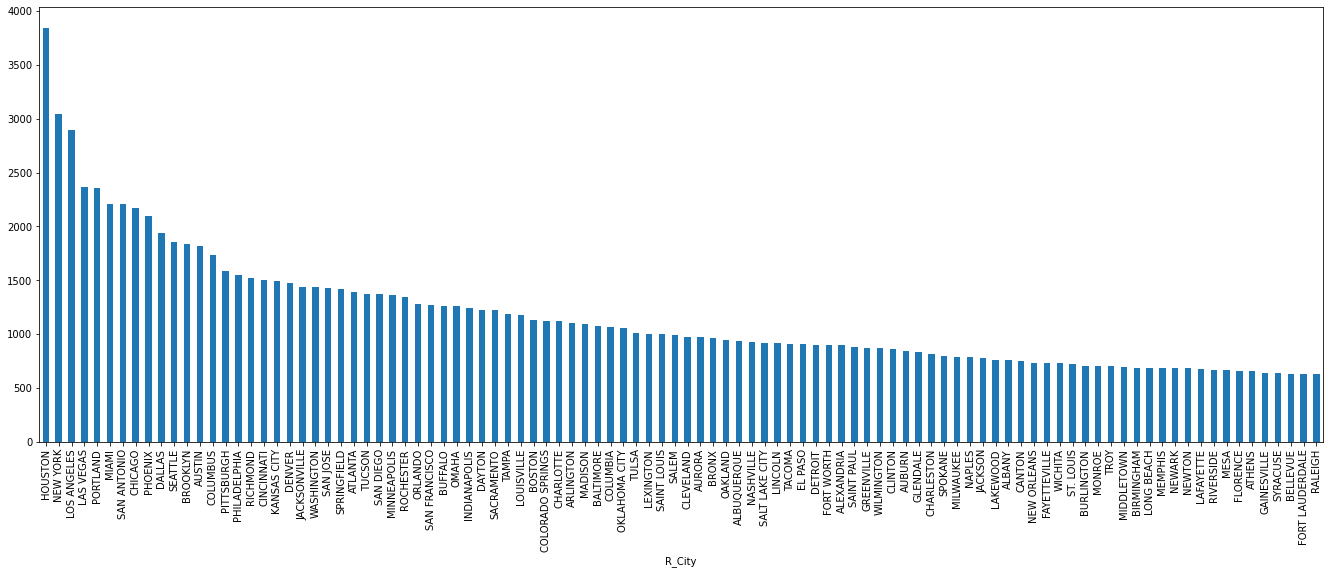

In [ ]:
final_df.groupby('R_City')['total_days'].sum().nlargest(100).plot(kind='bar', figsize=(23,8))

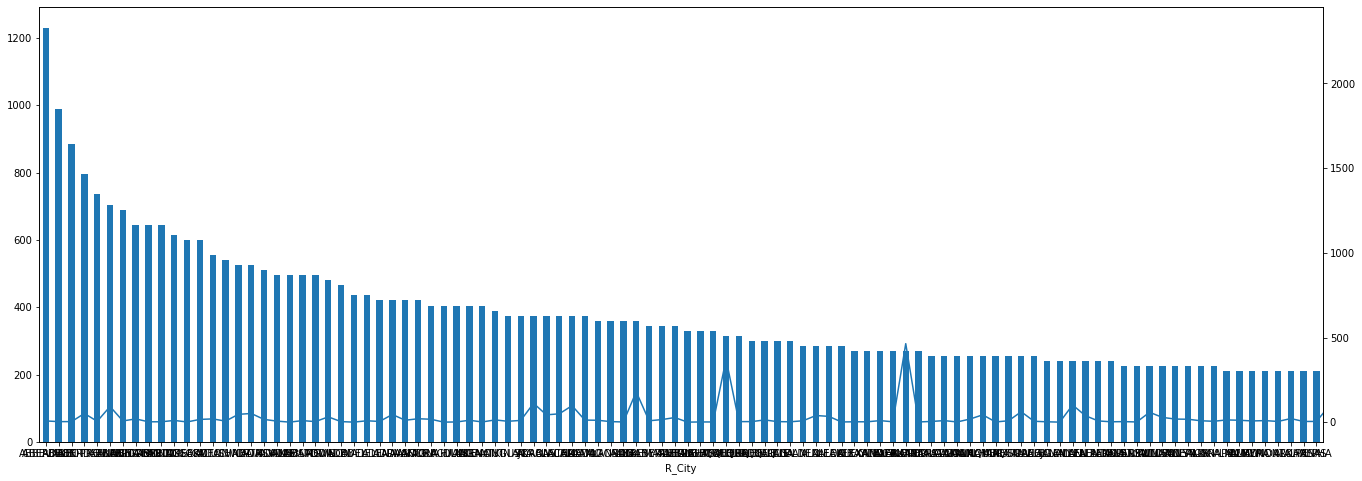

In [ ]:
final_df.groupby('R_City')['Transits'].sum().nlargest(100).plot(kind='bar', figsize=(23,8))
final_df.groupby('R_City')['Units sum'].sum().plot(secondary_y=True)

In [ ]:
from google.colab import files
final_df.to_csv('final_df.csv')
files.download('final_df.csv')